In [1]:
from boosted_lorenzetti.jobs import load_job
from boosted_lorenzetti.mlp.cli import inference as mlp_inference
from boosted_lorenzetti.mlp.jobs import KFoldTrainingJob
from boosted_lorenzetti.deeponet.cli import inference as deeponet_inference
from boosted_lorenzetti.deeponet.jobs import KFoldMLPUnstackedDeepONetJob
from boosted_lorenzetti.utils import set_logger
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import mlflow
import matplotlib as mpl
import mplhep
import numpy as np
import polars as pl

/home/lucasbanunes/miniconda3/envs/blzt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_logger()
plt.style.use(mplhep.style.ATLAS)
mpl.rc('text', usetex = True)
base_dir = Path.home().absolute() / 'data' / 'mestrado' / 'topicos_ml'
tracking_uri = str(base_dir / 'mlruns')
tracking_uri = f'file://{tracking_uri}'
logging.info(f'Setting MLflow tracking URI to {tracking_uri}')
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment('icassp-mlp')

2025-09-15 10:35:48 | INFO | root | 3300875415 | 7 | Setting MLflow tracking URI to file:///home/lucasbanunes/data/mestrado/topicos_ml/mlruns


<Experiment: artifact_location='file:///home/lucasbanunes/data/mestrado/topicos_ml/mlruns/714083779440500432', creation_time=1757783001833, experiment_id='714083779440500432', last_update_time=1757783001833, lifecycle_stage='active', name='icassp-mlp', tags={}>

In [3]:
def get_fold_statistics(kfold_job):
    if kfold_job.best_metric_mode == 'max':
        idx_selector = kfold_job.metrics.groupby('fold')[kfold_job.best_metric].idxmax()
    else:
        idx_selector = kfold_job.metrics.groupby('fold')[kfold_job.best_metric].idxmin()

    best_inits = kfold_job.metrics.loc[idx_selector, ['id', kfold_job.best_metric, 'fold']]
    mean = best_inits[kfold_job.best_metric].mean()
    std = best_inits[kfold_job.best_metric].std()
    return best_inits, mean, std

In [4]:
def get_child(kfold_job, training_job_id):
    for child in kfold_job.children:
        if child['job'].id_ == training_job_id:
            return child
    raise ValueError(f'No child with id {training_job_id} found in kfold job {kfold_job.id}')

In [5]:
jobs = {
    '6bd0c00490da4c0fb0d8e031e28284d5': {
        'label': 'MLP',
        'fold_predictions': {}
    },
    '2d4efb386fb64f5da0bbdcaec3ffbf73': {
        'label': 'DeepONet',
        'fold_predictions': {}
    }
}
for job_id, job_info in jobs.items():
    logging.info(f'Loading job {job_id}')
    job = load_job(job_id)
    jobs[job_id]['job'] = job
    jobs[job_id]['best_inits'], jobs[job_id]['mean'], jobs[job_id]['std'] = get_fold_statistics(jobs[job_id]['job'])

2025-09-15 10:35:49 | INFO | root | 720049041 | 12 | Loading job 6bd0c00490da4c0fb0d8e031e28284d5


2025-09-15 10:36:12 | INFO | root | 720049041 | 12 | Loading job 2d4efb386fb64f5da0bbdcaec3ffbf73


In [6]:
def get_mlp_inferences(
    job_info
):
    inferences = {}
    for _, row in job_info['best_inits'].iterrows():
        child = get_child(job_info['job'], row['id'])
        if child['fold'] != row['fold']:
            raise RuntimeError('Fold mismatch between kfold job and child job')
        logging.info(f'Running MLP inference for fold {row["fold"]} with training job {row["id"]}')
        job = child['job']
        inference_data = mlp_inference(
            job.db_path,
            job.id_,
            ring_col='cl_rings',
            table_name='data',
            filter=f'fold = {child["fold"]}'
        )
        inferences[child['fold']] = inference_data
    return inferences

In [7]:
def get_deeponet_inferences(
    job_info
):
    inferences = {}
    for _, row in job_info['best_inits'].iterrows():
        child = get_child(job_info['job'], row['id'])
        if child['fold'] != row['fold']:
            raise RuntimeError('Fold mismatch between kfold job and child job')
        logging.info(f'Running DeepONet inference for fold {row["fold"]} with training job {row["id"]}')
        job = child['job']
        inference_data = deeponet_inference(
            job.db_path,
            job.id_,
            table_name='data',
            filter=f'fold = {child["fold"]}'
        )
        inferences[child['fold']] = inference_data
    return inferences

In [8]:
for job_id, job_info in jobs.items():
    if job_info['label'] == 'MLP':
        jobs[job_id]['fold_predictions'] = get_mlp_inferences(job_info)
    elif job_info['label'] == 'DeepONet':
        jobs[job_id]['fold_predictions'] = get_deeponet_inferences(job_info)
    else:
        raise ValueError(f'Unknown job label {job_info["label"]}')

2025-09-15 10:36:38 | INFO | root | 3228207070 | 9 | Running MLP inference for fold 0 with training job 4274be1981f54e5abdd799dadd6e8e7b
2025-09-15 10:36:38 | INFO | root | cli | 221 | Infers using MLP model with run ID: 4274be1981f54e5abdd799dadd6e8e7b


2025-09-15 10:36:39 | INFO | root | 3228207070 | 9 | Running MLP inference for fold 1 with training job ccaf3cd6c88b46cfabce0ff4451244c6
2025-09-15 10:36:39 | INFO | root | cli | 221 | Infers using MLP model with run ID: ccaf3cd6c88b46cfabce0ff4451244c6


2025-09-15 10:36:40 | INFO | root | 3228207070 | 9 | Running MLP inference for fold 2 with training job d51628aa0bea4f04aa4cbc2c8031b5aa
2025-09-15 10:36:40 | INFO | root | cli | 221 | Infers using MLP model with run ID: d51628aa0bea4f04aa4cbc2c8031b5aa


2025-09-15 10:36:41 | INFO | root | 3228207070 | 9 | Running MLP inference for fold 3 with training job 35f061c729ac4f3898bd64f2d37e715c
2025-09-15 10:36:41 | INFO | root | cli | 221 | Infers using MLP model with run ID: 35f061c729ac4f3898bd64f2d37e715c


2025-09-15 10:36:43 | INFO | root | 3228207070 | 9 | Running MLP inference for fold 4 with training job d690c2ac438a44dd9af1355b1b680f39
2025-09-15 10:36:43 | INFO | root | cli | 221 | Infers using MLP model with run ID: d690c2ac438a44dd9af1355b1b680f39


2025-09-15 10:36:44 | INFO | root | 1543222412 | 9 | Running DeepONet inference for fold 0 with training job 3f100b3249854e7b94b7d81b052e4622
2025-09-15 10:36:44 | INFO | root | cli | 293 | Infers using MLP model with run ID: 3f100b3249854e7b94b7d81b052e4622


2025-09-15 10:36:46 | INFO | root | 1543222412 | 9 | Running DeepONet inference for fold 1 with training job a97fbb2ccf1b4eb9b45c81cefbe40883
2025-09-15 10:36:46 | INFO | root | cli | 293 | Infers using MLP model with run ID: a97fbb2ccf1b4eb9b45c81cefbe40883


2025-09-15 10:36:48 | INFO | root | 1543222412 | 9 | Running DeepONet inference for fold 2 with training job 136a19aba7d54000ab7797c6334aaee2
2025-09-15 10:36:48 | INFO | root | cli | 293 | Infers using MLP model with run ID: 136a19aba7d54000ab7797c6334aaee2


2025-09-15 10:36:49 | INFO | root | 1543222412 | 9 | Running DeepONet inference for fold 3 with training job 2be922495cb6492fafdaa840ac6bb3f8
2025-09-15 10:36:49 | INFO | root | cli | 293 | Infers using MLP model with run ID: 2be922495cb6492fafdaa840ac6bb3f8


2025-09-15 10:36:51 | INFO | root | 1543222412 | 9 | Running DeepONet inference for fold 4 with training job 12d9d01daac04dfba2c43083cff807ac
2025-09-15 10:36:51 | INFO | root | cli | 293 | Infers using MLP model with run ID: 12d9d01daac04dfba2c43083cff807ac


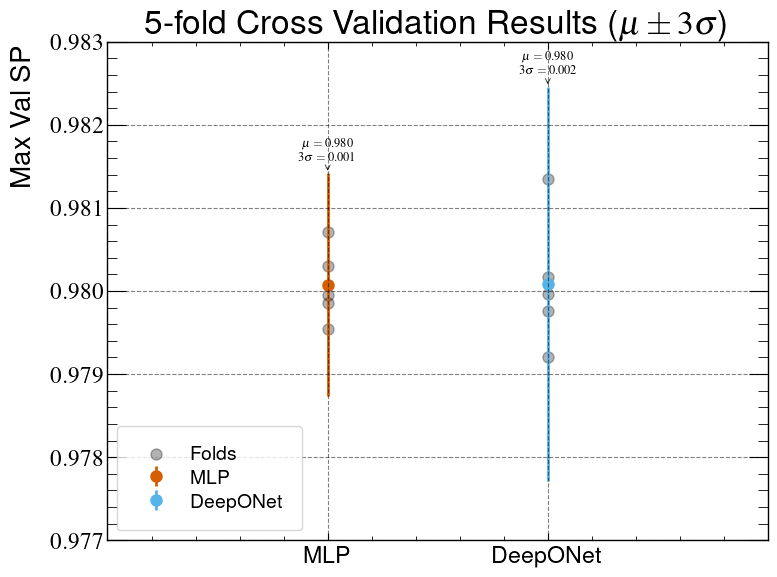

In [9]:
fig, ax = plt.subplots()
ax.grid(linestyle='--', alpha=0.5, color='k')
x = []
y = []
yerr = []
labels = []

for i, job_info in enumerate(jobs.values()):
    # x.append(job['label'])
    best_metric = job_info['job'].best_metric
    x.append(i)
    y.append(job_info['mean'])
    yerr.append(3*job_info['std'])
    labels.append(job_info['label'])
    ax.errorbar([i], [job_info['mean']], yerr=[3*job_info['std']],
                fmt='o', label=job_info['label'])
    samples_y = job_info['best_inits'][best_metric].to_numpy()
    samples_x = np.full(len(samples_y), i)
    ax.annotate(f'$\mu={job_info["mean"]:.3f}$\n$3\sigma={3*job_info["std"]:.3f}$',
                xy=(i, job_info['mean'] + 3*job_info['std']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                arrowprops=dict(arrowstyle='->', lw=0.5))
    if i == 0:
        ax.scatter(samples_x, samples_y, color='k', alpha=.3, label='Folds')
    else:
        ax.scatter(samples_x, samples_y, color='k', alpha=.3)

ax.legend(frameon=True)
ax.set(
    title=r'5-fold Cross Validation Results ($\mu \pm 3\sigma$)',
    ylabel='Max Val SP',
    xlim=(-1, 2)
)
ax.set_xticks(
    ticks=x,
    labels=labels
)
fig.tight_layout()

2025-09-15 10:36:54 | INFO | root | 1137167539 | 24 | Fold 0: stat=54720.0, p=1.1785656353584224e-23


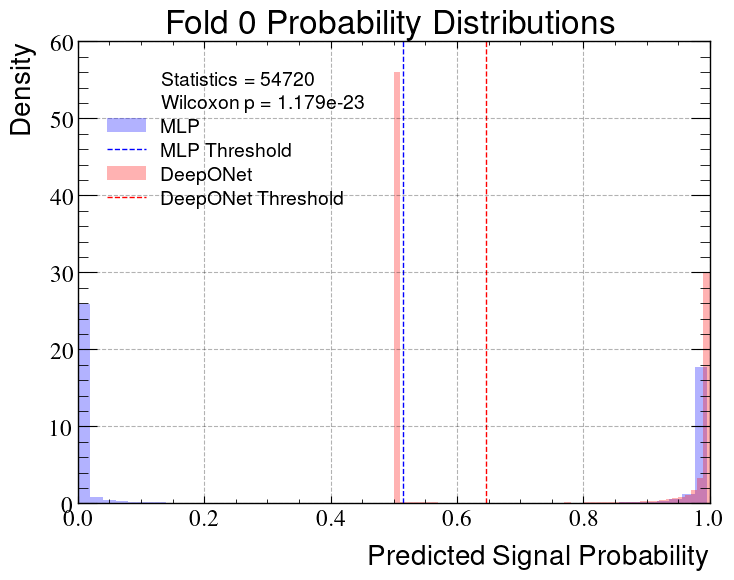

2025-09-15 10:36:54 | INFO | root | 1137167539 | 24 | Fold 1: stat=40180.0, p=1.8944679887626984e-34


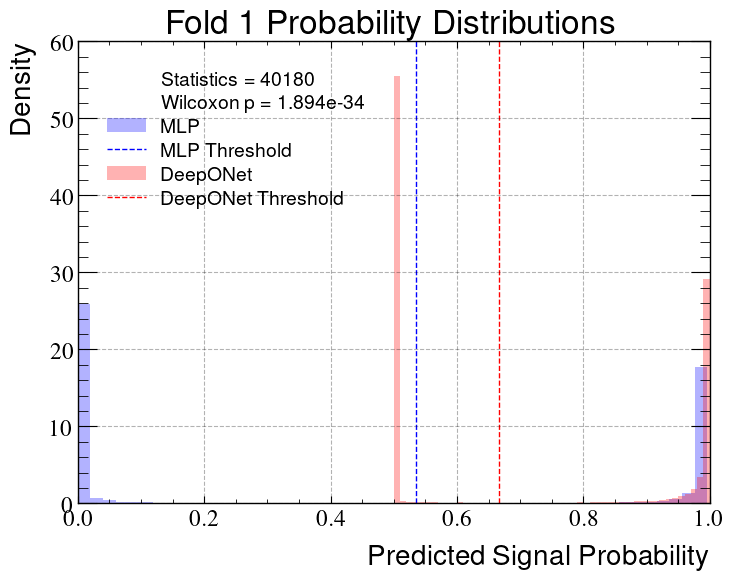

2025-09-15 10:36:55 | INFO | root | 1137167539 | 24 | Fold 2: stat=60023.0, p=4.092096026022608e-21


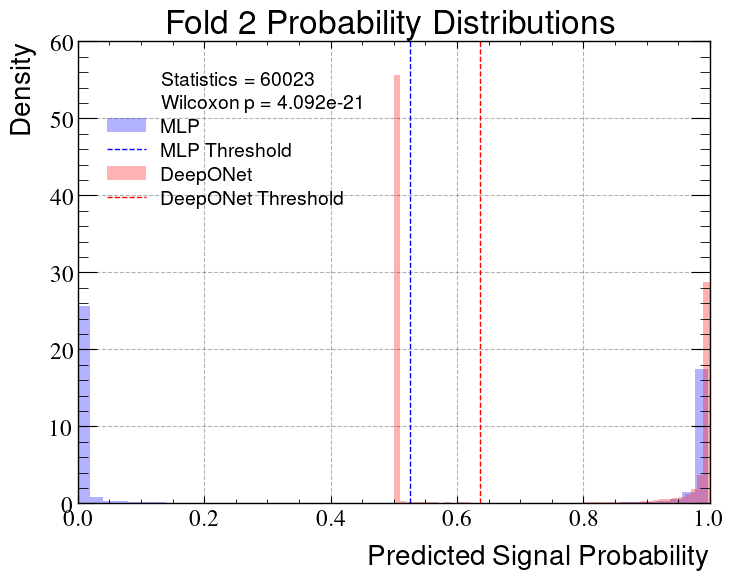

2025-09-15 10:36:55 | INFO | root | 1137167539 | 24 | Fold 3: stat=64980.0, p=2.1668441532964324e-06


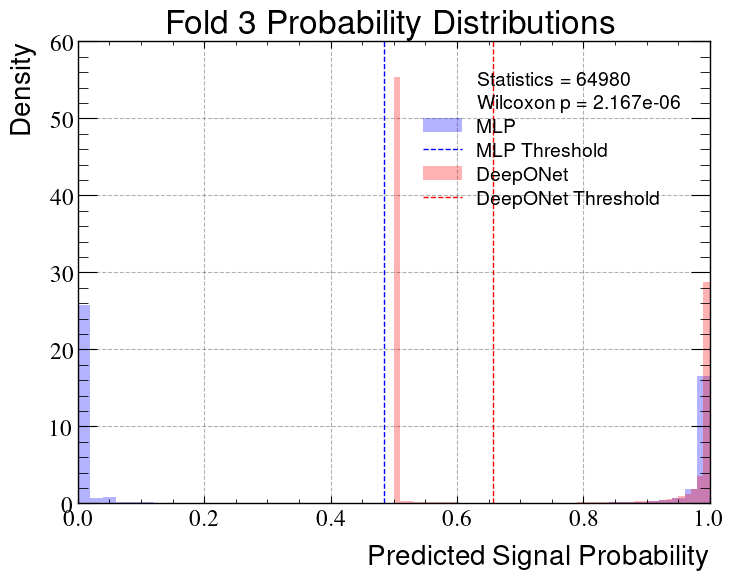

2025-09-15 10:36:55 | INFO | root | 1137167539 | 24 | Fold 4: stat=50634.0, p=5.648814373082416e-09


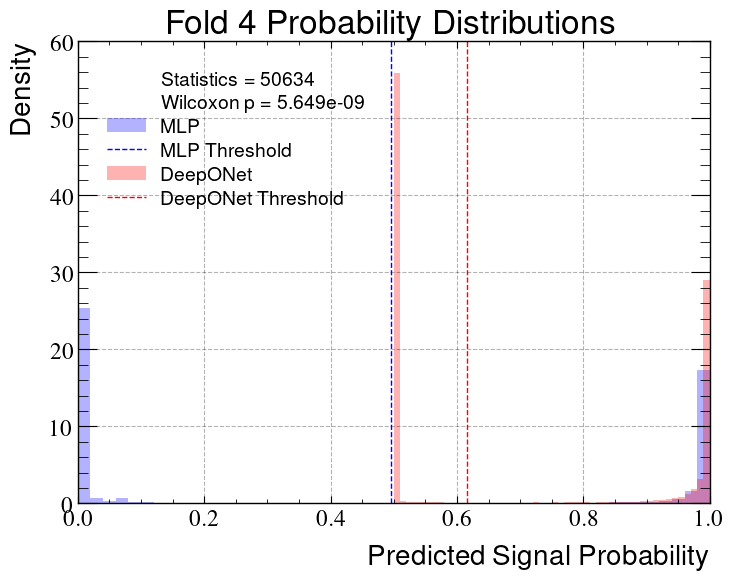

In [10]:
from scipy.stats import wilcoxon

for fold in range(5):
    mlp_job = jobs['6bd0c00490da4c0fb0d8e031e28284d5']['job']
    mlp_best_inits = jobs['6bd0c00490da4c0fb0d8e031e28284d5']['best_inits']
    mlp_best_init_id = mlp_best_inits[mlp_best_inits['fold'] == fold]['id'].values[0]
    mlp_best_init_job = get_child(mlp_job, mlp_best_init_id)['job']
    mlp_preds: pl.DataFrame = jobs['6bd0c00490da4c0fb0d8e031e28284d5']['fold_predictions'][fold]

    deeponet_job = jobs['2d4efb386fb64f5da0bbdcaec3ffbf73']['job']
    deeponet_best_inits = jobs['2d4efb386fb64f5da0bbdcaec3ffbf73']['best_inits']
    deeponet_best_init_id = deeponet_best_inits[deeponet_best_inits['fold'] == fold]['id'].values[0]
    deeponet_best_init_job = get_child(deeponet_job, deeponet_best_init_id)['job']
    deeponet_preds: pl.DataFrame = jobs['2d4efb386fb64f5da0bbdcaec3ffbf73']['fold_predictions'][fold]
    joined = mlp_preds.join(
        deeponet_preds,
        on='id',
        how='inner',
        suffix='_deeponet'
    )
    if len(joined) != len(mlp_preds) or len(joined) != len(deeponet_preds):
        raise RuntimeError('Joined predictions length mismatch')
    res = wilcoxon(joined['predicted_label'].to_numpy(), joined['predicted_label_deeponet'].to_numpy())
    logging.info(f'Fold {fold}: stat={res.statistic}, p={res.pvalue}')

    fig, ax = plt.subplots()
    ax.grid(linestyle='--', alpha=0.3, color='k')
    ax.plot([], [], ' ', label=f'Statistics = {int(res.statistic)}')
    ax.plot([], [], ' ', label=f'Wilcoxon p = {res.pvalue:.3e}')
    ax.hist(
        mlp_preds['proba'].to_numpy(),
        density=True,
        label='MLP',
        color='blue',
        alpha=0.3,
        bins=50
    )
    ax.axvline(
        mlp_best_init_job.metrics['train']['max_sp_thresh'],
        color='blue',
        linestyle='--',
        linewidth=1,
        label='MLP Threshold'
    )
    ax.hist(
        deeponet_preds['proba'].to_numpy(),
        density=True,
        label='DeepONet',
        color='red',
        alpha=0.3,
        bins=50
    )
    ax.axvline(
        deeponet_best_init_job.metrics['train']['max_sp_thresh'],
        color='red',
        linestyle='--',
        linewidth=1,
        label='DeepONet Threshold'
    )
    ax.legend()
    ax.set(
        title=f'Fold {fold} Probability Distributions',
        ylabel='Density',
        xlabel='Predicted Signal Probability',
    )
    plt.show()